In [1]:
from google.colab import drive                                                      
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from PIL import Image
from keras.models import Model 
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils import np_utils
from keras.callbacks import History
import cv2 
import numpy as np
import pandas as pd 
import os

df_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Input/train_labels.csv")
df_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Input/sample_submission.csv")

TRAIN_DIR = "/content/drive/My Drive/Colab Notebooks/Input/Train1/Train.part001/"
TEST_DIR = "/content/drive/My Drive/Colab Notebooks/Input/Train1/Train.part002/"

path = "/content/drive/My Drive/Colab Notebooks/Input/train/"


print('Train Images = ',len(os.listdir(TRAIN_DIR)))
print('Test Images = ',len(os.listdir(TEST_DIR)))
print('Shape of train DataFrame',df_train.shape)
print('Shape of test DataFrame',df_test.shape)





Train Images =  442
Test Images =  443
Shape of train DataFrame (220025, 2)
Shape of test DataFrame (57458, 2)


In [0]:

num_train = 8000
num_test = 2000

height, width, depth = 96, 3, 96
num_classes = 2


X_train = np.zeros((2*num_train,96,96,3))
y_train = np.zeros(2*num_train)

X_test = np.zeros((2*num_test,96,96,3))
y_test = np.zeros(2*num_test)



for i in range (0,num_train):
    pic = path + df_train.iloc[i]['id'] + '.tif' # путь к i-ой картинке в папке
    im = Image.open(pic) # открыли картинку
    X_train[i] = np.array(im)
    y_train[i] = df_train.iloc[i]['label']
 
    
for i in range (0,num_test):
    pic = path + df_train.iloc[i + num_train]['id'] + '.tif' # путь к i-ой картинке в папке
    im = Image.open(pic) # открыли картинку
    X_test[i] = np.array(im)
    y_test[i] = df_train.iloc[i + num_train]['label']



In [0]:
for i in range (num_train ,2*num_train):
    pic = path + df_train.iloc[i]['id'] + '.tif' # путь к i-ой картинке в папке
    im = Image.open(pic) # открыли картинку
    X_train[i] = np.array(im)
    y_train[i] = df_train.iloc[i]['label']
 
    
for i in range (num_test,2*num_test):
    pic = path + df_train.iloc[i + num_train]['id'] + '.tif' # путь к i-ой картинке в папке
    im = Image.open(pic) # открыли картинку
    X_test[i] = np.array(im)
    y_test[i] = df_train.iloc[i + num_train]['label']

In [11]:
X_test.shape

(4000, 96, 96, 3)

In [14]:
batch_size = 64
num_epochs = 200
kernel_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 8 # we will initially have 16 kernels per conv. layer...
conv_depth_2 = 16 # ...switching to 32 after the first pooling layer
conv_depth_3 = 32 
conv_depth_4 = 64 
conv_depth_5 = 128 
drop_prob_1 = 0.1 # dropout after pooling with probability 0.25
drop_prob_2 = 0.5 # 
hidden_size = 16


#X_train = X_train.astype('float32') 
#X_test = X_test.astype('float32')
history = History()
X_train /= np.max(X_train) 
X_test /= np.max(X_train)
#Y_train = np_utils.to_categorical(y_train, num_classes) 
#Y_test = np_utils.to_categorical(y_test, num_classes)


inp = Input(shape=(depth, height, width)) 
conv_1 = Convolution2D(conv_depth_1, kernel_size, kernel_size, border_mode='same', activation='relu')(inp)
pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_1)
drop_1 = Dropout(drop_prob_1)(pool_1)
conv_2 = Convolution2D(conv_depth_2, kernel_size, kernel_size, border_mode='same', activation='relu')(drop_1)
pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)
drop_2 = Dropout(drop_prob_1)(pool_2)
conv_3 = Convolution2D(conv_depth_3, kernel_size, kernel_size, border_mode='same', activation='relu')(drop_1)
pool_3 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_3)
drop_3 = Dropout(drop_prob_1)(pool_3)
conv_4 = Convolution2D(conv_depth_4, kernel_size, kernel_size, border_mode='same', activation='relu')(drop_3)
pool_4 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)
drop_4 = Dropout(drop_prob_1)(pool_4)
conv_5 = Convolution2D(conv_depth_5, kernel_size, kernel_size, border_mode='same', activation='relu')(drop_4)
pool_5 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_5)
drop_5 = Dropout(drop_prob_1)(pool_5)
flat = Flatten()(drop_5)
hidden = Dense(hidden_size, activation='relu')(flat)
out = Dense(1, activation='sigmoid')(hidden)

model = Model(input=inp, output=out) 

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy']) 

model.fit(X_train, y_train, 
          batch_size=batch_size, nb_epoch=num_epochs,
          verbose=1, validation_split=0.1, callbacks=[history]) 

model.evaluate(X_test, Y_test, verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Model` ca

Train on 14400 samples, validate on 1600 samples
Epoch 1/200
14400/14400 [==============================] - 11s 794us/step - loss: 0.5696 - acc: 0.7056 - val_loss: 0.5491 - val_acc: 0.7431
Epoch 2/200
14400/14400 [==============================] - 11s 739us/step - loss: 0.4796 - acc: 0.7794 - val_loss: 0.5335 - val_acc: 0.7550
Epoch 3/200
14400/14400 [==============================] - 10s 680us/step - loss: 0.4691 - acc: 0.7844 - val_loss: 0.6170 - val_acc: 0.6931
Epoch 4/200
14400/14400 [==============================] - 10s 703us/step - loss: 0.4638 - acc: 0.7890 - val_loss: 0.4634 - val_acc: 0.7856
Epoch 5/200
14400/14400 [==============================] - 11s 740us/step - loss: 0.4443 - acc: 0.8008 - val_loss: 0.4519 - val_acc: 0.7975
Epoch 6/200
14400/14400 [==============================] - 11s 753us/step - loss: 0.4309 - acc: 0.8085 - val_loss: 0.4550 - val_acc: 0.7881
Epoch 7/200
14400/14400 [==============================] - 11s 750us/step - loss: 0.4185 - acc: 0.8175 - val_lo

ValueError: ignored

In [15]:
model.evaluate(X_test, y_test, verbose=1)

4000/4000 [==============================] - 2s 380us/step


[6.577091129302978, 0.59175]

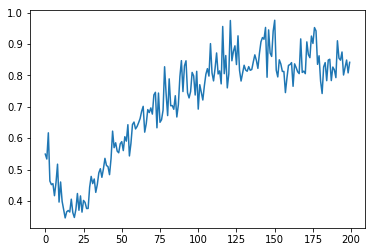

In [16]:
import matplotlib.pyplot as plt
#print(history.history.keys())
#print(history.history['val_loss'])
plt.plot(history.history['val_loss'])

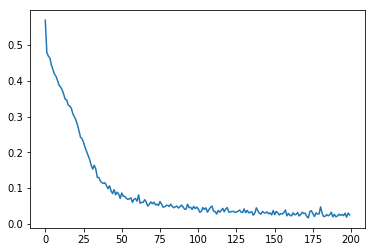

In [17]:
plt.plot(history.history['loss'])

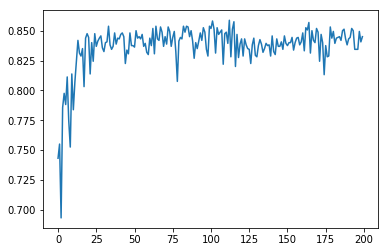

In [18]:
plt.plot(history.history['val_acc'])

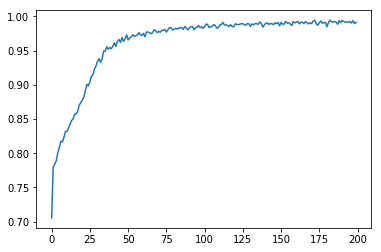

In [19]:
plt.plot(history.history['acc'])

In [0]:
predicts=model.predict(X_test)


In [21]:
 from sklearn.metrics import classification_report
true = y_test.reshape((4000,1))
true = true.astype('float32')
print(classification_report(true, predicts > 0.5))

              precision    recall  f1-score   support

         0.0       0.59      1.00      0.74      2371
         1.0       0.25      0.00      0.00      1629

    accuracy                           0.59      4000
   macro avg       0.42      0.50      0.37      4000
weighted avg       0.45      0.59      0.44      4000

